In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import os
import cv2
import json
import urllib
from pathlib import Path
from collections import defaultdict

In [3]:
import numpy as np
import pandas as pd
from PIL import ImageDraw, ImageFont
from cycler import cycler
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import matplotlib.colors as mcolors
from matplotlib import patches, patheffects

In [4]:
import torch
from torch import nn
from torch import optim
from torch.nn import functional as F

In [5]:
# fast.ai explicit dependencies
from fastai.conv_learner import ConvLearner, ConvnetBuilder, resnet34
from fastai.conv_learner import tfms_from_model, CropType, TfmType
from fastai.conv_learner import RandomRotate, RandomLighting, RandomFlip
from fastai.dataset import ImageClassifierData, Dataset, to_np, get_cv_idxs, split_by_idx

/home/ck/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [6]:
torch.cuda.device(0)

In [7]:
PATH        = Path.home() / 'data' / 'voc2007'
JPEG        = Path('VOCdevkit/VOC2007/JPEGImages') 
IMAGES      = 'images'
ANNOTATIONS = 'annotations'
CATEGORIES  = 'categories'
FILE_NAME   = 'file_name'
ID          = 'id'
BBOX        = 'bbox'
IMG_ID      = 'image_id'
CAT_ID      = 'category_id'

In [8]:
def parse_annotations(arr):
    parsed = defaultdict(list)
    for annot in arr:
        if annot['ignore']:
            continue
        bbox_raw = annot[BBOX]
        bbox_hw = from_voc(bbox_raw)
        parsed[annot[IMG_ID]].append((bbox_hw, annot[CAT_ID]))
    return dict(parsed)


def from_voc(bbox):
    """
    Converts Pascal bounding box from (x, y, w, h) into
    (top, left, bottom, right) format, and switch x/y coordinates to
    make a converted array indexes consistent with Numpy.
    """
    x, y, w, h = bbox
    new_box = [y, x, y + h - 1, x + w - 1]
    return np.array(new_box)


def to_voc(bbox):
    top, left, bottom, right = bbox
    new_box = [left, top, right - left + 1, bottom - top + 1]
    return np.array(new_box)

In [9]:
with open(PATH / 'pascal_train2007.json') as file:
    train_json = json.load(file)

categories = {obj[ID]: obj['name'] for obj in train_json[CATEGORIES]}
train_files = {obj[ID]: obj[FILE_NAME] for obj in train_json[IMAGES]}
train_indexes = [obj[ID] for obj in train_json[IMAGES]]
train_annotations = parse_annotations(train_json[ANNOTATIONS])

In [10]:
def open_image(fn):
    """ Opens an image using OpenCV given the file path.

    Arguments:
        fn: the file path of the image

    Returns:
        The image in RGB format as numpy array of floats normalized
        to range between 0.0 - 1.0

    """
    flags = cv2.IMREAD_UNCHANGED + cv2.IMREAD_ANYDEPTH + cv2.IMREAD_ANYCOLOR
    if not os.path.exists(fn) and not str(fn).startswith("http"):
        raise OSError('No such file or directory: {}'.format(fn))
    elif os.path.isdir(fn) and not str(fn).startswith("http"):
        raise OSError('Is a directory: {}'.format(fn))
    else:
        try:
            if str(fn).startswith("http"):
                req = urllib.urlopen(str(fn))
                image = np.asarray(bytearray(req.read()), dtype="uint8")
                im = cv2.imdecode(image, flags).astype(np.float32)/255
            else:
                im = cv2.imread(str(fn), flags).astype(np.float32)/255
            if im is None:
                raise OSError(f'File not recognized by opencv: {fn}')
            return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        except Exception as e:
            raise OSError('Error handling image at: {}'.format(fn)) from e

In [11]:
class ImagePlotter:
    """Helper class visualizing the dataset's images."""
    
    def __init__(self, root, annotations, files, categories, **fig_kwargs):
        self.root = root
        self.annotations = annotations
        self.files = files
        self.categories = categories
        self.fig_kwargs = fig_kwargs
        
    def show(self, index, ax=None):
        self.draw(index, ax)
        plt.show()
        
    def draw(self, index, ax=None):
        annotation = self.annotations[index]
        image = open_image(self.root / self.files[index])
        ax = self.draw_image(image, ax=ax)
        for bbox, category in annotation:
            bbox = to_voc(bbox)
            classes = self.categories[category]
            self.draw_rect(ax, bbox)
            self.draw_text(ax, bbox[:2], classes, size=16)
        return ax
    
    def show_images(self, images, targets, class_names, dims=(3, 4), figsize=(12, 12), grid=True):
        fig, axes = plt.subplots(*dims, figsize=figsize)
        for i, ax in enumerate(axes.flat):
            image = images[i]
            [non_zero] = np.nonzero(targets[i] > 0.4)
            self.draw_image(image, ax=ax, grid=grid)
            if len(non_zero) > 0:
                classes = '\n'.join([class_names[index] for index in non_zero])
                self.draw_text(ax, (0, 0), classes)
            else:
                classes = '<NONE>'
                self.draw_text(ax, (0, 0), classes, color='salmon')
        plt.tight_layout()
        plt.show()
        
    def show_ground_truth(self, images, boxes, classes, dims=(3, 4), figsize=(12, 12)):
        
        def get_cmap(N):
            color_norm  = mcolors.Normalize(vmin=0, vmax=N-1)
            return cmx.ScalarMappable(norm=color_norm, cmap='Set3').to_rgba
        
        n_colors = 12
        cmap = get_cmap(n_colors)
        colors_list = [cmap(float(x)) for x in range(n_colors)]
        
        fig, axes = plt.subplots(*dims, figsize=figsize)
        for i, ax in enumerate(axes.flat):
            image = images[i]
            image_classes = classes[i]
            image_boxes = [box for box in boxes[i].reshape(-1, 4)]
            self.draw_image(image, ax=ax)
            for j, (box, target) in enumerate(zip(image_boxes, image_classes)):
                if box[2] <= 0:
                    continue
                box = to_voc(box)
                color = colors_list[j % n_colors]
                self.draw_rect(ax, box, color=color)
                self.draw_text(ax, box[:2], f'{j}: {target}', color=color)

    def draw_image(self, image, grid=False, n_cells=8, ax=None):
        if not ax:
            fig, ax = plt.subplots(**self.fig_kwargs)
        ax.imshow(image)
        if grid:
            width, height = image.shape[:2]
            ax.set_xticks(np.linspace(0, width, n_cells))
            ax.set_yticks(np.linspace(0, height, n_cells))
            ax.grid()
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        return ax
    
    def draw_outline(self, obj, lw=4):
        effects = [
            patheffects.Stroke(linewidth=lw, foreground='black'),
            patheffects.Normal()]
        obj.set_path_effects(effects)
        
    def draw_rect(self, ax, bbox, lw=4, color='white'):
        rect = patches.Rectangle(
            bbox[:2], *bbox[-2:],
            fill=False, edgecolor=color, lw=2)
        patch = ax.add_patch(rect)
        self.draw_outline(patch, lw)
        
    def draw_text(self, ax, xy, text, size=14, outline=1, color='white'):
        text = ax.text(
            *xy, text, 
            va='top', color=color,
            fontsize=size, weight='bold')
        self.draw_outline(text, outline)

In [12]:
plotter = ImagePlotter(PATH / JPEG, train_annotations, train_files, categories)

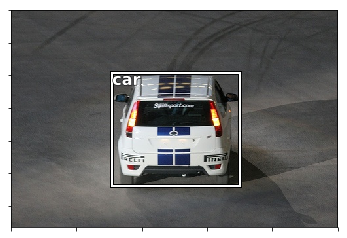

In [13]:
plotter.draw(12)

In [14]:
factory = resnet34
batch_size = 64
CSV = PATH / 'tmp' / 'mc.csv'

In [15]:
transforms = tfms_from_model(factory, 224, crop_type=CropType.NO)
data = ImageClassifierData.from_csv(PATH, JPEG, CSV, tfms=transforms, bs=batch_size)
learner = ConvLearner.pretrained(factory, data)
learner.opt_fn = optim.Adam

In [16]:
lr = 2e-2
learner.fit(lr, 1, cycle_len=3, use_clr=(32, 5))

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   <lambda>                  
    0      0.327253   0.145264   0.9519    
    1      0.175491   0.080716   0.9732                    
    2      0.118504   0.075699   0.9744                    



[0.07569902968406678, 0.9744000101089477]

In [17]:
lrs = np.array([lr/100, lr/10, lr])
learner.freeze_to(-2)
learner.fit(lrs/10, 1, cycle_len=5, use_clr=(32, 5))

HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

epoch      trn_loss   val_loss   <lambda>                   
    0      0.073255   0.089035   0.9719    
    1      0.054697   0.082662   0.9722                     
    2      0.039858   0.078357   0.9755                     
    3      0.027753   0.075166   0.9766                     
    4      0.019417   0.077015   0.9756                     



[0.07701532357931137, 0.9756000161170959]

In [18]:
y = learner.predict()
x, _ = next(iter(data.val_dl))
x = to_np(x)
images = data.val_ds.denorm(x)

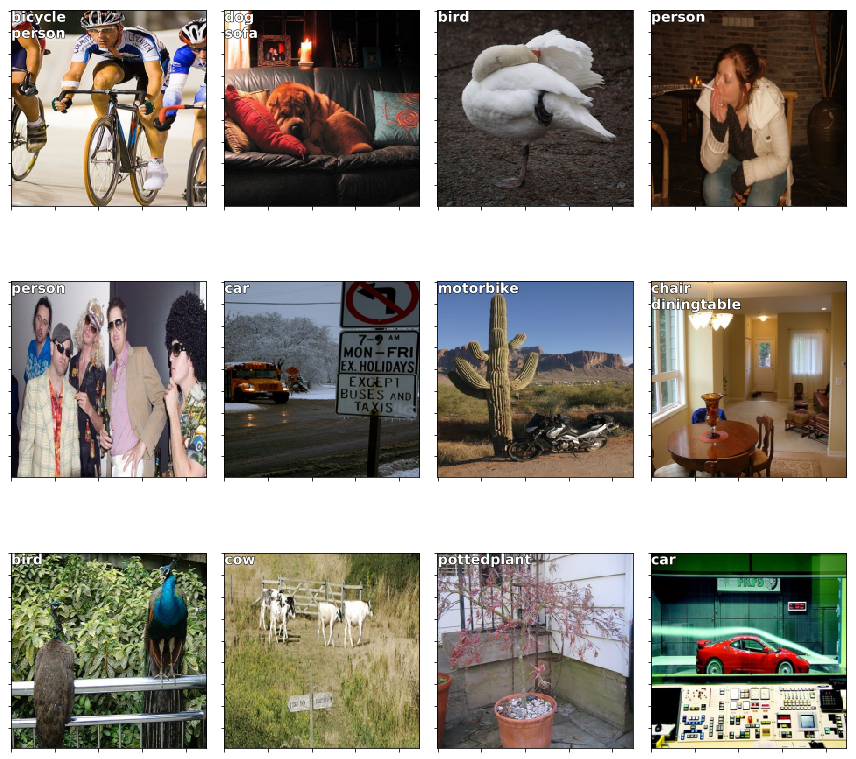

In [19]:
plotter.show_images(images, y, data.classes, grid=False)

## Bounding Box per Cell

In [20]:
CLAS_CSV = PATH/'tmp/clas.csv'
MBB_CSV = PATH/'tmp/mbb.csv'

factory = resnet34
size = 224
batch_size = 64

In [21]:
multi_class = [
    [categories[an[1]] for an in train_annotations[index]] 
    for index in train_indexes]

multi_class_bb = [
    np.concatenate([an[0] for an in train_annotations[index]])
    for index in train_indexes]

multi_class_strings = [
    ' '.join(str(digit) for digit in box)
    for box in multi_class_bb]

In [22]:
id2cat = list(categories.values())
cat2id = {v:k for k, v in enumerate(id2cat)}
multi_class_ids = np.array([
    np.array([cat2id[cls] for cls in class_list])
    for class_list in multi_class])

In [23]:
valid_indexes = get_cv_idxs(len(train_files))
((valid_mc, train_mc), ) = split_by_idx(valid_indexes, multi_class_ids)

In [24]:
df = pd.DataFrame({
    'fn': [train_files[i] for i in train_indexes],
    'bbox': multi_class_strings
}, columns=['fn', 'bbox'])
df.to_csv(MBB_CSV, index=False)

In [25]:
augmentations = [
    RandomRotate(3, p=0.5, tfm_y=TfmType.COORD),
    RandomLighting(0.05, 0.05, tfm_y=TfmType.COORD),
    RandomFlip(tfm_y=TfmType.COORD)
]

transforms = tfms_from_model(
    factory, 
    size,
    crop_type=CropType.NO, 
    tfm_y=TfmType.COORD, 
    aug_tfms=augmentations)

data = ImageClassifierData.from_csv(
    PATH, JPEG, MBB_CSV,
    tfms=transforms, 
    bs=batch_size, 
    continuous=True,
    num_workers=4)

In [26]:
class ConcatLblDataset(Dataset):
    
    def __init__(self, ds, y2):
        self.ds = ds
        self.y2 = y2
        self.sz = ds.sz
        
    def __len__(self): 
        return len(self.ds)
    
    def __getitem__(self, i):
        x, y = self.ds[i]
        return (x, (y, self.y2[i]))

In [27]:
trn_ds2 = ConcatLblDataset(data.trn_ds, train_mc)
val_ds2 = ConcatLblDataset(data.val_ds, valid_mc)
data.trn_dl.dataset = trn_ds2
data.val_dl.dataset = val_ds2

In [28]:
x, y = to_np(next(iter(data.trn_dl)))
x = data.trn_ds.ds.denorm(x)
y_boxes = y[0]
y_classes = [
    [id2cat[index] if index < len(id2cat) else 'bg' for index in indexes] 
    for indexes in y[1]]

In [45]:
for x, y in iter(data.trn_dl):
    boxes, classes = y
#     print(boxes.shape)
    print(classes.shape)

torch.Size([64, 13])
torch.Size([64, 15])
torch.Size([64, 14])
torch.Size([64, 11])
torch.Size([64, 12])
torch.Size([64, 13])
torch.Size([64, 12])
torch.Size([64, 11])
torch.Size([64, 10])
torch.Size([64, 13])
torch.Size([64, 11])
torch.Size([64, 10])
torch.Size([64, 8])
torch.Size([64, 9])
torch.Size([64, 15])
torch.Size([64, 13])
torch.Size([64, 6])
torch.Size([64, 9])
torch.Size([64, 15])
torch.Size([64, 10])
torch.Size([64, 13])
torch.Size([64, 16])
torch.Size([64, 10])
torch.Size([64, 12])
torch.Size([64, 12])
torch.Size([64, 10])
torch.Size([64, 8])
torch.Size([64, 10])
torch.Size([64, 10])
torch.Size([64, 9])
torch.Size([64, 13])
torch.Size([17, 19])


In [48]:
data.trn_dl??

In [35]:
y_classes

[['aeroplane',
  'aeroplane',
  'aeroplane',
  'aeroplane',
  'aeroplane',
  'aeroplane',
  'aeroplane',
  'aeroplane',
  'chair',
  'person',
  'person',
  'person',
  'person'],
 ['aeroplane',
  'aeroplane',
  'aeroplane',
  'aeroplane',
  'aeroplane',
  'aeroplane',
  'aeroplane',
  'aeroplane',
  'person',
  'person',
  'person',
  'bottle',
  'bottle'],
 ['aeroplane',
  'aeroplane',
  'aeroplane',
  'aeroplane',
  'aeroplane',
  'aeroplane',
  'aeroplane',
  'aeroplane',
  'aeroplane',
  'car',
  'car',
  'bus',
  'bus'],
 ['aeroplane',
  'aeroplane',
  'bicycle',
  'bicycle',
  'bicycle',
  'bicycle',
  'bicycle',
  'person',
  'person',
  'person',
  'person',
  'person',
  'person'],
 ['aeroplane',
  'aeroplane',
  'aeroplane',
  'aeroplane',
  'aeroplane',
  'aeroplane',
  'aeroplane',
  'aeroplane',
  'aeroplane',
  'aeroplane',
  'aeroplane',
  'dog',
  'sofa'],
 ['aeroplane',
  'aeroplane',
  'aeroplane',
  'aeroplane',
  'aeroplane',
  'aeroplane',
  'aeroplane',
  'aeropl

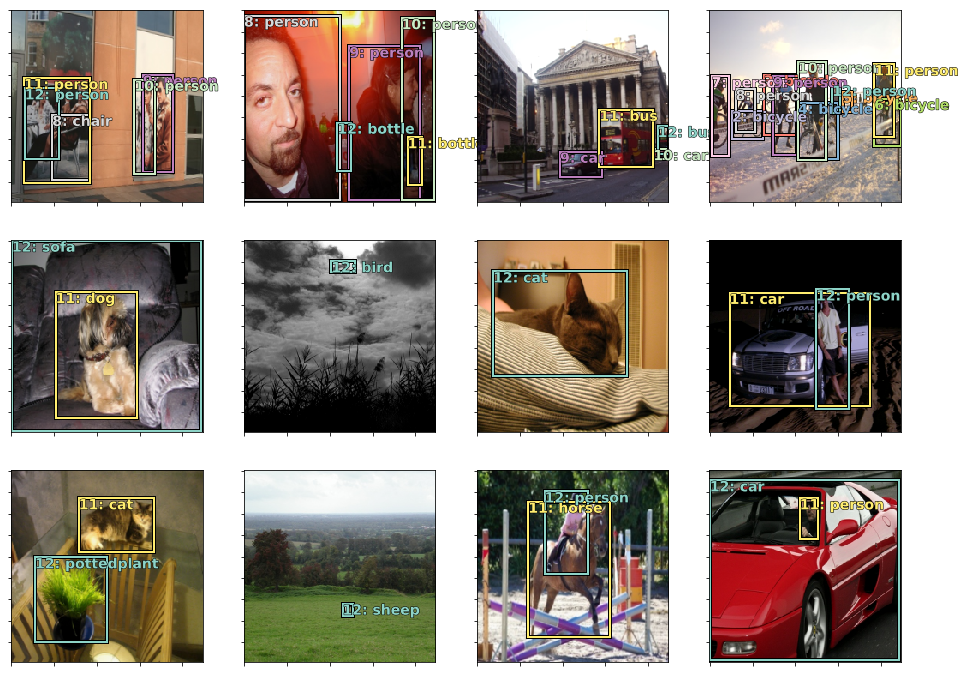

In [29]:
plotter.show_ground_truth(x, y_boxes, y_classes, figsize=(16, 12))

## 4x4 Grid Model

In [35]:
def make_grid(anchors=4, k=1):
    offset = 1/(anchors*2)
    points = np.linspace(offset, 1 - offset, anchors)
    anchors_x = np.repeat(points, anchors)
    anchors_y = np.tile(points, anchors)
    centers = np.stack([anchors_x, anchors_y], axis=1)
    sizes = np.array([(1/anchors, 1/anchors) for i in range(anchors*anchors)])
    grid = np.c_[np.tile(centers, (k, 1)), np.tile(sizes, (k, 1))]
    return grid

In [36]:
k = 1

[[0.125 0.125 0.25  0.25 ]
 [0.125 0.375 0.25  0.25 ]
 [0.125 0.625 0.25  0.25 ]
 [0.125 0.875 0.25  0.25 ]
 [0.375 0.125 0.25  0.25 ]
 [0.375 0.375 0.25  0.25 ]
 [0.375 0.625 0.25  0.25 ]
 [0.375 0.875 0.25  0.25 ]
 [0.625 0.125 0.25  0.25 ]
 [0.625 0.375 0.25  0.25 ]
 [0.625 0.625 0.25  0.25 ]
 [0.625 0.875 0.25  0.25 ]
 [0.875 0.125 0.25  0.25 ]
 [0.875 0.375 0.25  0.25 ]
 [0.875 0.625 0.25  0.25 ]
 [0.875 0.875 0.25  0.25 ]]


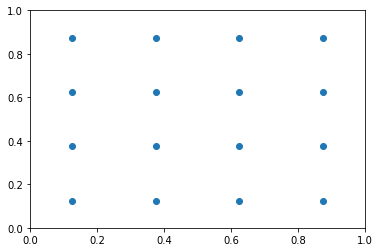

In [37]:
grid = make_grid(k=k)
xs, ys = grid[:, 0], grid[:, 1]
plt.scatter(xs, ys)
plt.xlim(0, 1)
plt.ylim(0, 1)
print(grid)

In [38]:
def hw2corners(grid):
    """Converts height/width grid format into top-left/bottom-right format."""

    centers, sizes = grid[:, :2], grid[:, 2:]
    return np.c_[centers - sizes/2, centers + sizes/2]

In [39]:
hw2corners(grid)

array([[0.  , 0.  , 0.25, 0.25],
       [0.  , 0.25, 0.25, 0.5 ],
       [0.  , 0.5 , 0.25, 0.75],
       [0.  , 0.75, 0.25, 1.  ],
       [0.25, 0.  , 0.5 , 0.25],
       [0.25, 0.25, 0.5 , 0.5 ],
       [0.25, 0.5 , 0.5 , 0.75],
       [0.25, 0.75, 0.5 , 1.  ],
       [0.5 , 0.  , 0.75, 0.25],
       [0.5 , 0.25, 0.75, 0.5 ],
       [0.5 , 0.5 , 0.75, 0.75],
       [0.5 , 0.75, 0.75, 1.  ],
       [0.75, 0.  , 1.  , 0.25],
       [0.75, 0.25, 1.  , 0.5 ],
       [0.75, 0.5 , 1.  , 0.75],
       [0.75, 0.75, 1.  , 1.  ]])

In [40]:
n_classes = len(id2cat) + 1
n_activations = k*(4 + n_classes)

In [50]:
class StdConv(nn.Module):
    
    def __init__(self, ni, nf, stride=2, dropout=0.1):
        super().__init__()
        self.conv = nn.Conv2d(ni, nf, 3, stride=stride, padding=1)
        self.bn = nn.BatchNorm2d(nf)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        return self.dropout(self.bn(F.relu(self.conv(x))))

In [51]:
def flatten_conv(x, k):
    bs, nf, gx, gy = x.size()
    x = x.permute(0,2,3,1).contiguous()
    return x.view(bs, -1, nf//k)

In [52]:
class OutConv(nn.Module):
    def __init__(self, k, nin, bias):
        super().__init__()
        self.k = k
        self.oconv1 = nn.Conv2d(nin, (len(id2cat) + 1)*k, 3, padding=1)
        self.oconv2 = nn.Conv2d(nin, 4*k, 3, padding=1)
        self.oconv1.bias.data.zero_().add_(bias)
        
    def forward(self, x):
        return [flatten_conv(self.oconv1(x), self.k),
                flatten_conv(self.oconv2(x), self.k)]

In [53]:
class SSD_Head(nn.Module):
    def __init__(self, k, bias):
        super().__init__()
        self.drop = nn.Dropout(0.25)
        self.sconv0 = StdConv(512,256, stride=1)
#         self.sconv1 = StdConv(256,256)
        self.sconv2 = StdConv(256,256)
        self.out = OutConv(k, 256, bias)
        
    def forward(self, x):
        x = self.drop(F.relu(x))
        x = self.sconv0(x)
#         x = self.sconv1(x)
        x = self.sconv2(x)
        return self.out(x)

In [58]:
head_reg4 = SSD_Head(k, -3.)
models = ConvnetBuilder(factory, 0, 0, 0, custom_head=head_reg4)
learn = ConvLearner(data, models)
learn.opt_fn = optim.Adam
k

1